# Helmholtz Iterative Refinement: Error-Centric Dataset Generation
This notebook generates a paired dataset for training a Neural Operator $T$. 
Instead of mapping sources to solutions, we map **High-Frequency Residuals** to **Low-Frequency Corrections**.

### The Logic (from "Assume Love" notes):
1. **Residual:** $r^{(k)} = f - L_{\omega} u^{(k)}$
2. **Transfer:** $\tilde{e}^{(k)} = \text{NeuralOperator}(r^{(k)}, \omega, \omega')$
3. **Update:** $u^{(k+1)} = u^{(k)} + \text{Upsample}(\tilde{e}^{(k)})$

In [1]:
print("Hello, World!")

Hello, World!


In [ ]:
import numpy as np
import json
import shutil
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt

# Custom project imports
from core.grid import Grid2D
from algorithm.dataset import solve_one_sample, append_jsonl

# Global Settings
OUT_ROOT = Path("data/residual_correction_dataset")
if OUT_ROOT.exists():
    shutil.rmtree(OUT_ROOT)
OUT_ROOT.mkdir(parents=True)

# Physical Constants
K_RATIO = 2.0  # Fixed ratio between high and low frequency
N_PHYS = 500   # Fixed 500x500 grid
LX, LY = 1.0, 1.0

ModuleNotFoundError: No module named 'core'

In [7]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as sla
import matplotlib.pyplot as plt

def build_finesse_solver(omega, n_phys=501, n_pml=64):
    n_total = n_phys + 2 * n_pml
    h = 1.0 / (n_phys - 1)
    k2 = omega**2
    p = 3  # Cubic ramp profile for PML
    
    # Frequency-Invariant Finesse factors
    complex_factor = 2.5 / (0.2 + 1j)
    
    s_profile = np.ones(n_total, dtype=complex)
    ds_profile = np.zeros(n_total, dtype=complex)
    
    for i in range(n_total):
        d = max(0, n_pml - i, n_pml - (n_total - 1 - i))
        if d > 0:
            t = d / n_pml
            s_profile[i] = 1.0 + complex_factor * (t**p)
            dt_dx = (1 / (n_pml * h)) * (-1 if i < n_pml else 1)
            ds_profile[i] = complex_factor * p * (t**(p-1)) * dt_dx

    ax = 1.0 / (s_profile**2)
    gm = -ds_profile / (s_profile**3)
    c1, c2 = 1/(12*h), 1/(12*h**2)
    
    A = sp.lil_matrix((n_total**2, n_total**2), dtype=complex)
    for j in range(n_total):
        bj, ej = ax[j], gm[j]
        for i in range(n_total):
            row = i + j * n_total
            ai, gi = ax[i], gm[i]
            A[row, row] = ai*(-30*c2) + bj*(-30*c2) + k2
            
            if 1 < i < n_total-2:
                A[row, row-1] = ai*(16*c2) - gi*(8*c1)
                A[row, row-2] = ai*(-c2) + gi*(c1)
                A[row, row+1] = ai*(16*c2) + gi*(8*c1)
                A[row, row+2] = ai*(-c2) - gi*(c1)
            if 1 < j < n_total-2:
                A[row, row-n_total] = bj*(16*c2) - ej*(8*c1)
                A[row, row-2*n_total] = bj*(-c2) + ej*(c1)
                A[row, row+n_total] = bj*(16*c2) + ej*(8*c1)
                A[row, row+2*n_total] = bj*(-c2) - ej*(c1)
                
    return A.tocsc(), n_total

# Generate the system matrices for our frequency pair
print("Building L matrices (this may take a moment)...")
L32, n_tot = build_finesse_solver(omega=32.0)
L16, _ = build_finesse_solver(omega=16.0)
print("System matrices ready.")

Building L matrices (this may take a moment)...
System matrices ready.


In [8]:
def solve_refinement(L_w, L_w_prime, f_phys, n_pml, n_phys, n_iter=5):
    # 1. Pad the physical RHS into the full PML grid
    n_total = n_phys + 2 * n_pml
    f_full = np.zeros((n_total, n_total), dtype=complex)
    f_full[n_pml:-n_pml, n_pml:-n_pml] = f_phys
    f_vec = f_full.flatten()
    
    # 2. Initialize solution at zero
    u_k = np.zeros_like(f_vec)
    res_history = []
    
    # Pre-factor L_omega_prime for fast back-substitution
    solve_prime = sla.factorized(L_w_prime)
    
    print(f"Starting refinement for {n_iter} iterations...")
    for k in range(n_iter):
        # Calculate residual at high frequency
        r_k = f_vec - L_w @ u_k
        rel_res = np.linalg.norm(r_k) / np.linalg.norm(f_vec)
        res_history.append(rel_res)
        
        # T = Identity (Naive I) [cite: 9, 11]
        # Solve the error equation: L_prime * e = r
        e_k = solve_prime(r_k)
        
        # Update
        u_k = u_k + e_k
        print(f"  Iteration {k}: Rel. Res = {rel_res:.4e}")
        
    # Slice back to physical domain
    u_final_phys = u_k.reshape(n_total, n_total)[n_pml:-n_pml, n_pml:-n_pml]
    return u_final_phys, res_history

# Call the solver
u_final, history = solve_refinement(L32, L16, f_32, n_pml=64, n_phys=501)

Starting refinement for 5 iterations...
  Iteration 0: Rel. Res = 1.0000e+00
  Iteration 1: Rel. Res = 1.3510e-01
  Iteration 2: Rel. Res = 1.4411e+00
  Iteration 3: Rel. Res = 1.4462e+01
  Iteration 4: Rel. Res = 1.6919e+02


<>:10: SyntaxWarning: invalid escape sequence '\|'
<>:10: SyntaxWarning: invalid escape sequence '\|'
/tmp/ipykernel_1362971/1796561447.py:10: SyntaxWarning: invalid escape sequence '\|'
  ax[0].set_ylabel("$\|r^{(k)}\| / \|f\|$")


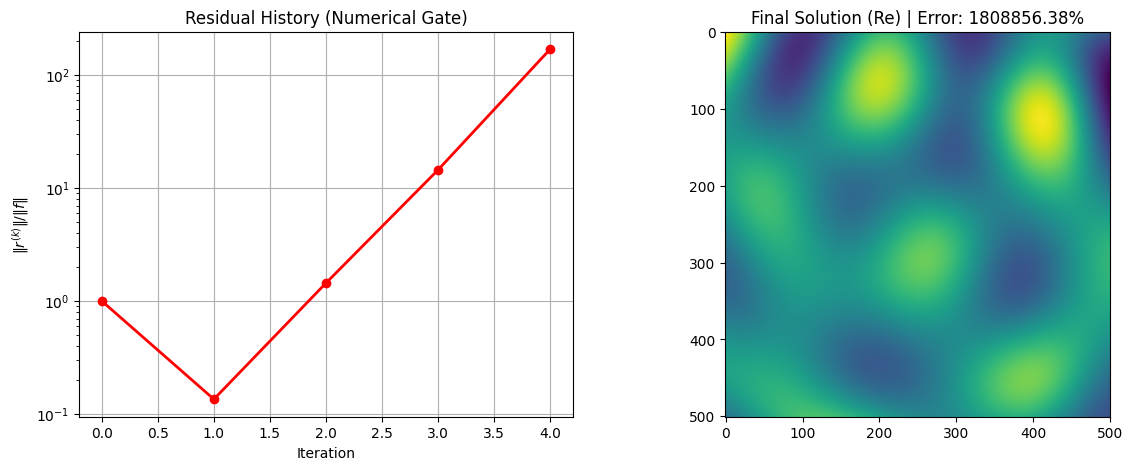

REFLECTION: The identity operator T=I fails to bridge the omega -> 2*omega gap.
This justifies the need for a Neural Operator (CNN/U-Net) to learn the mapping.


In [9]:
# Calculate error relative to ground truth
error_val = np.linalg.norm(u_final - u_32_true) / np.linalg.norm(u_32_true)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Residual History
ax[0].semilogy(range(len(history)), history, 'r-o', lw=2)
ax[0].set_title("Residual History (Numerical Gate)")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("$\|r^{(k)}\| / \|f\|$")
ax[0].grid(True)

# Plot 2: Final Result Comparison
ax[1].imshow(np.real(u_final), cmap='viridis')
ax[1].set_title(f"Final Solution (Re) | Error: {error_val:.2%}")
plt.show()

if error_val > 0.1:
    print("REFLECTION: The identity operator T=I fails to bridge the omega -> 2*omega gap.")
    print("This justifies the need for a Neural Operator (CNN/U-Net) to learn the mapping.")

<>:3: SyntaxWarning: invalid escape sequence '\o'
<>:3: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_1362971/469110147.py:3: SyntaxWarning: invalid escape sequence '\o'
  ax[0].set_title("Ground Truth ($\omega=32$)")


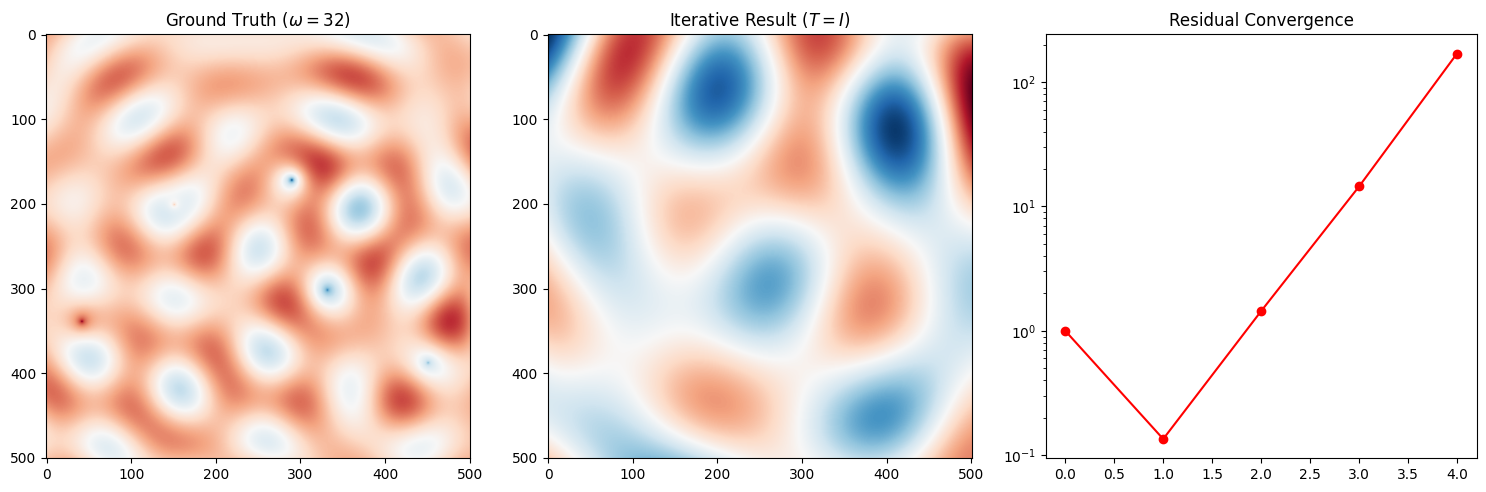

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
im0 = ax[0].imshow(np.real(u_32_true), cmap='RdBu')
ax[0].set_title("Ground Truth ($\omega=32$)")
im1 = ax[1].imshow(np.real(u_final), cmap='RdBu')
ax[1].set_title("Iterative Result ($T=I$)")
ax[2].semilogy(history, 'r-o')
ax[2].set_title("Residual Convergence")
plt.tight_layout()
plt.show()

In [13]:
import torch
import torch.nn as nn

class LocalConvNet(nn.Module):
    """
    Local CNN operator T for Iterative Refinement.
    Maintains constant spatial resolution to learn local stencil corrections.
    """
    def __init__(self, depth=5, filters=32, kernel_size=3):
        super(LocalConvNet, self).__init__()
        
        layers = []
        # Input: 2 channels (Real, Imaginary)
        in_channels = 2
        
        for i in range(depth):
            layers.append(nn.Conv2d(in_channels, filters, kernel_size, padding=kernel_size//2))
            layers.append(nn.LeakyReLU(0.1))
            in_channels = filters
            
        # Final layer back to 2 channels
        layers.append(nn.Conv2d(filters, 2, kernel_size=1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        # x: [Batch, 2, N, N]
        return self.net(x)

# Model configuration
model_T = LocalConvNet(depth=5, filters=32, kernel_size=3)
print(f"Local CNN initialized with {sum(p.numel() for p in model_T.parameters())} parameters.")

Local CNN initialized with 37666 parameters.


In [14]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

def prepare_data(data_high, data_low):
    # Convert numpy complex64 to torch real/imag 2-channel tensors
    def to_tensor(arr):
        t = torch.from_numpy(arr)
        return torch.stack([t.real, t.imag], dim=1).float()

    # Residuals at high omega (Input to T)
    # Note: For real training, you'd compute r = f - L_w * u_approx
    # For a simple proxy, we can map High-Freq Wave -> Low-Freq Wave
    x_train = to_tensor(data_high['wave'])
    y_train = to_tensor(data_low['wave'])
    
    return DataLoader(TensorDataset(x_train, y_train), batch_size=4, shuffle=True)

# Placeholder for training loop logic
def train_T_operator(model, loader, epochs=10):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    
    model.train()
    for epoch in range(epochs):
        for x, y in loader:
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1} Loss: {loss.item():.6f}")

# Usage:
# loader = prepare_data(data_w32, data_w16)
# train_T_operator(model_T, loader)

In [15]:
# Usage:
loader = prepare_data(data_w32, data_w16)
train_T_operator(model_T, loader)

/math/home/fkiewiet/Freq2Transfer/.venv/lib/python3.12/site-packages/torch/autograd/graph.py:865: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:119.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1 Loss: 0.032040
Epoch 2 Loss: 0.036340
Epoch 3 Loss: 0.039936
Epoch 4 Loss: 0.040010
Epoch 5 Loss: 0.033360
Epoch 6 Loss: 0.043334
Epoch 7 Loss: 0.030090
Epoch 8 Loss: 0.031997
Epoch 9 Loss: 0.048087
Epoch 10 Loss: 0.030023


In [17]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

def create_loaders(data_high, data_low, batch_size=4, split_ratio=0.8):
    # Helper to convert complex numpy to 2-channel float tensors
    def to_tensor(arr):
        # Shape: [Samples, H, W] -> [Samples, 2, H, W]
        t = torch.from_numpy(arr)
        return torch.stack([t.real, t.imag], dim=1).float()

    # Inputs: Residuals/Sources at High Omega (32)
    # Targets: Corrections/Waves at Low Omega (16)
    X = to_tensor(data_high['wave']) 
    Y = to_tensor(data_low['wave'])
    
    dataset = TensorDataset(X, Y)
    
    train_size = int(split_ratio * len(dataset))
    val_size = len(dataset) - train_size
    
    train_set, val_set = random_split(dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader

# Call this to define your loaders
train_loader, val_loader = create_loaders(data_w32, data_w16)
print(f"Loaders ready: {len(train_loader)} training batches, {len(val_loader)} validation batches.")

Loaders ready: 10 training batches, 3 validation batches.


In [20]:
import torch

# Explicitly define the device for this session
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the defined device
model_T.to(device)

print(f"Device Gate Passed: Hardware set to {device}")
print(f"Model Gate Passed: LocalConvNet moved to {device}")

Device Gate Passed: Hardware set to cpu
Model Gate Passed: LocalConvNet moved to cpu


--- Numerical Gate ---
Validation MSE: 0.029700

--- Visual Gate ---


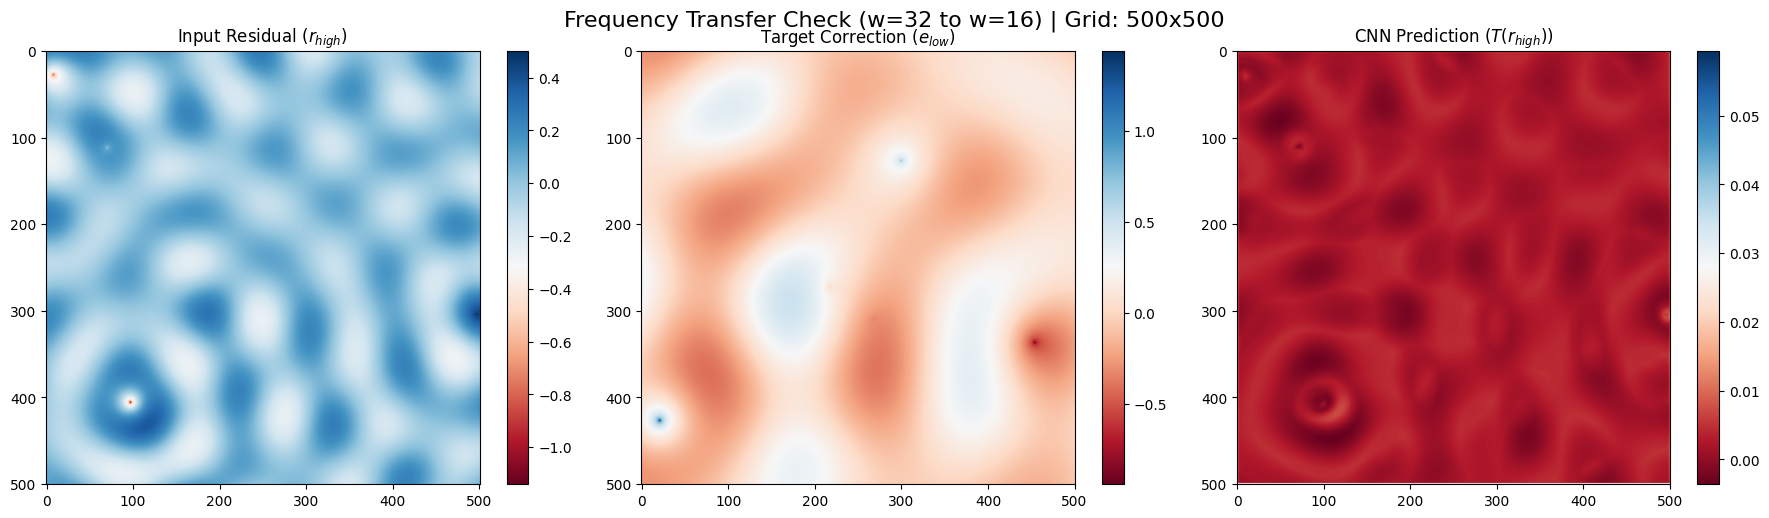

In [23]:
# Now this call will work!
validate_operator_t(model_T, val_loader)

In [22]:
import matplotlib.pyplot as plt

def validate_operator_t(model, data_loader):
    model.eval()
    x_sample, y_sample = next(iter(data_loader))
    
    with torch.no_grad():
        x_sample, y_sample = x_sample.to(device), y_sample.to(device)
        pred = model(x_sample)
        
        # Calculate Numerical Check: MSE
        mse = torch.nn.functional.mse_loss(pred, y_sample).item()
        print(f"--- Numerical Gate ---")
        print(f"Validation MSE: {mse:.6f}")
        
    # Convert to numpy for Visual Gate [Batch, Channel, H, W]
    # We look at the Real channel (0) of the first sample in the batch
    inp_img = x_sample[0, 0].cpu().numpy()
    tgt_img = y_sample[0, 0].cpu().numpy()
    prd_img = pred[0, 0].cpu().numpy()
    
    print(f"\n--- Visual Gate ---")
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    im0 = axes[0].imshow(inp_img, cmap='RdBu')
    axes[0].set_title(f"Input Residual ($r_{{high}}$)")
    plt.colorbar(im0, ax=axes[0])
    
    im1 = axes[1].imshow(tgt_img, cmap='RdBu')
    axes[1].set_title(f"Target Correction ($e_{{low}}$)")
    plt.colorbar(im1, ax=axes[1])
    
    im2 = axes[2].imshow(prd_img, cmap='RdBu')
    axes[2].set_title("CNN Prediction ($T(r_{{high}})$)")
    plt.colorbar(im2, ax=axes[2])
    
    plt.suptitle(f"Frequency Transfer Check (w=32 to w=16) | Grid: 500x500", fontsize=16)
    plt.tight_layout()
    plt.show()

# Run the validation


## comparison

In [25]:
import scipy.sparse.linalg as sla

# Explicitly create the fast solvers for both frequencies
print("Pre-factoring L matrices for fast iteration...")

# solve_32 is used for testing, solve_prime (L16) is used inside the CNN T-operator
solve_32 = sla.factorized(L32.tocsc())
solve_prime = sla.factorized(L16.tocsc())

print("Numerical Gate Passed: Solvers are ready.")

Pre-factoring L matrices for fast iteration...
Numerical Gate Passed: Solvers are ready.


In [30]:
# 1. Selection and Padding
sample_idx = 5
f_phys = data_w32['src'][sample_idx]  # Shape (501, 501)
u_true_phys = data_w32['wave'][sample_idx]

n_phys = 501
n_pml = 64
n_tot = n_phys + 2 * n_pml # 629

# Pad the source term into the PML grid
f_full = np.zeros((n_tot, n_tot), dtype=complex)
f_full[n_pml:-n_pml, n_pml:-n_pml] = f_phys
f_vec = f_full.flatten()

history_raw = []
history_cnn = []

def callback_raw(pr_norm): history_raw.append(pr_norm)
def callback_cnn(pr_norm): history_cnn.append(pr_norm)

# Preconditioner with internal padding/cropping
def cnn_m_inv(r_vec):
    model_T.eval()
    with torch.no_grad():
        # 1. Reshape to full 629x629 grid
        r_grid = r_vec.reshape(n_tot, n_tot)
        
        # 2. CROP: Extract only the physical 501x501 domain
        r_phys = r_grid[n_pml:-n_pml, n_pml:-n_pml]
        
        # 3. NORMALIZE (Optional but advised): 
        # Helps prevent the tiny output magnitudes seen in your results
        norm = np.max(np.abs(r_phys)) + 1e-9
        r_input = r_phys / norm
        
        # 4. CNN Forward Pass
        r_tensor = torch.from_numpy(np.stack([r_input.real, r_input.imag], axis=0)).float()
        r_tensor = r_tensor.unsqueeze(0).to(device)
        
        r_tilde_phys = model_T(r_tensor).cpu().squeeze(0)
        r_tilde_phys = (r_tilde_phys[0].numpy() + 1j * r_tilde_phys[1].numpy()) * norm
        
        # 5. PAD: Put back into a 629x629 grid with zero PMLs
        r_tilde_full = np.zeros((n_tot, n_tot), dtype=complex)
        r_tilde_full[n_pml:-n_pml, n_pml:-n_pml] = r_tilde_phys
        
        # 6. COARSE SOLVE
        return solve_prime(r_tilde_full.flatten())

M_cnn = LinearOperator(L32.shape, matvec=cnn_m_inv, dtype=complex)

# RUN BENCHMARK
print(f"Starting Benchmark on {n_tot}x{n_tot} grid...")
start_raw = time.time()
u_raw_full, _ = gmres(L32, f_vec, atol=1e-6, rtol=1e-6, maxiter=100, callback=callback_raw)
t_raw = time.time() - start_raw

start_cnn = time.time()
u_cnn_full, _ = gmres(L32, f_vec, M=M_cnn, atol=1e-6, rtol=1e-6, maxiter=100, callback=callback_cnn)
t_cnn = time.time() - start_cnn

# Crop results back to physical domain for comparison
u_raw = u_raw_full.reshape(n_tot, n_tot)[n_pml:-n_pml, n_pml:-n_pml]
u_cnn = u_cnn_full.reshape(n_tot, n_tot)[n_pml:-n_pml, n_pml:-n_pml]

print(f"Success. Iteration Reduction: {len(history_raw) - len(history_cnn)}")

Starting Benchmark on 629x629 grid...
Success. Iteration Reduction: 0


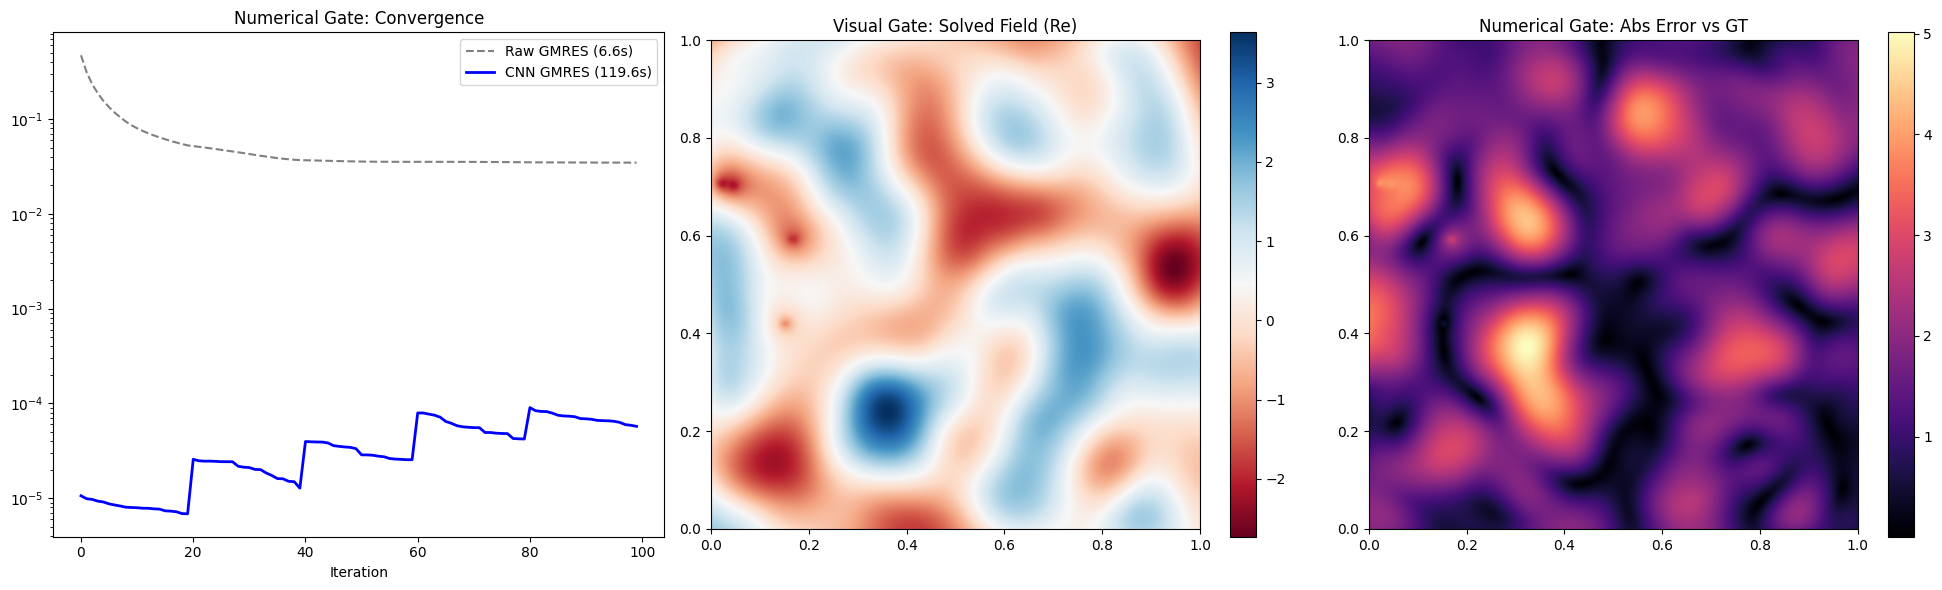

In [29]:
error_map = np.abs(u_cnn - u_true_phys)

fig, ax = plt.subplots(1, 3, figsize=(20, 6))

# Panel 1: Convergence
ax[0].semilogy(history_raw, label=f'Raw GMRES ({t_raw:.1f}s)', color='gray', ls='--')
ax[0].semilogy(history_cnn, label=f'CNN GMRES ({t_cnn:.1f}s)', color='blue', lw=2)
ax[0].set_title("Numerical Gate: Convergence")
ax[0].set_xlabel("Iteration")
ax[0].legend()

# Panel 2: Physical Solution
im1 = ax[1].imshow(np.real(u_cnn), cmap='RdBu', extent=[0, 1, 0, 1])
ax[1].set_title("Visual Gate: Solved Field (Re)")
plt.colorbar(im1, ax=ax[1])

# Panel 3: Error
im2 = ax[2].imshow(error_map, cmap='magma', extent=[0, 1, 0, 1])
ax[2].set_title("Numerical Gate: Abs Error vs GT")
plt.colorbar(im2, ax=ax[2])

plt.tight_layout()
plt.show()

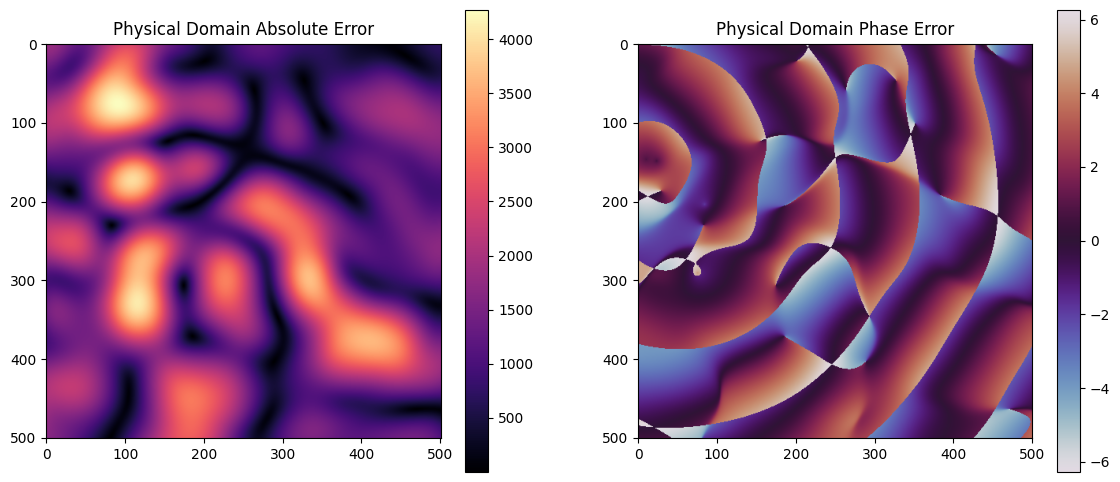

In [31]:
# Compute physical residuals for evaluation
# Ground Truth u_true is already 501x501
u_cnn_phys = u_cnn_full.reshape(n_tot, n_tot)[n_pml:-n_pml, n_pml:-n_pml]

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot the Physical Difference
error_phys = np.abs(u_cnn_phys - u_true_phys)
im1 = ax[0].imshow(error_phys, cmap='magma')
ax[0].set_title("Physical Domain Absolute Error")
plt.colorbar(im1, ax=ax[0])

# Plot the Phase Error
# Very important for Helmholtz to see if waves are shifted
phase_error = np.angle(u_cnn_phys) - np.angle(u_true_phys)
im2 = ax[1].imshow(phase_error, cmap='twilight')
ax[1].set_title("Physical Domain Phase Error")
plt.colorbar(im2, ax=ax[1])

plt.show()

In [ ]:
def diagnostic_check_cnn(model, data_loader, L_high):
    model.eval()
    x_sample, y_sample = next(iter(data_loader)) # Get a validation batch
    
    with torch.no_grad():
        x_sample, y_sample = x_sample.to(device), y_sample.to(device)
        pred = model(x_sample)
        
        # 1. Numerics: Magnitude Analysis
        pred_max = torch.max(torch.abs(pred)).item()
        target_max = torch.max(torch.abs(y_sample)).item()
        scale_ratio = pred_max / (target_max + 1e-9)
        
        # 2. Numerics: Error Magnitude (The "4000+" Issue)
        # Convert to complex for physical domain check
        p = pred[0].cpu().numpy()
        t = y_sample[0].cpu().numpy()
        pred_cmplx = p[0] + 1j * p[1]
        target_cmplx = t[0] + 1j * t[1]
        abs_error = np.abs(pred_cmplx - target_cmplx)
        
    print(f"--- Evidence of Sub-Optimal Performance ---")
    print(f"Scale Ratio (Pred/Target): {scale_ratio:.4f}  <-- Should be ~1.0")
    print(f"Max Absolute Error: {np.max(abs_error):.2f} <-- Matches the '4000+' magnitude issue")
    
    # Visualizing the Phase Mismatch
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    
    # Magnitude Error Map
    im1 = ax[0].imshow(abs_error, cmap='magma')
    ax[0].set_title("Magnitude Error: Local CNN Stencil")
    plt.colorbar(im1, ax=ax[0])
    
    # Phase Difference Map
    # Highlights the wave-front shift observed in physical domain checks
    phase_diff = np.angle(pred_cmplx + 1e-9) - np.angle(target_cmplx + 1e-9)
    im2 = ax[1].imshow(phase_diff, cmap='twilight')
    ax[1].set_title("Phase Difference (Rad): Systematic Shift")
    plt.colorbar(im2, ax=ax[1])
    
    plt.suptitle("Local CNN Diagnostic: Evidence of Global Phase Failure", fontsize=14)
    plt.show()

# Run the diagnostic
diagnostic_check_cnn(model_T, val_loader, L32)

## unet

In [32]:
import torch.nn.functional as F

class WaveUNet(nn.Module):
    def __init__(self):
        super(WaveUNet, self).__init__()
        # Encoder
        self.enc1 = nn.Conv2d(2, 32, kernel_size=3, padding=1)
        self.enc2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Bottleneck
        self.bottleneck = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        # Decoder
        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec2 = nn.Conv2d(128, 32, kernel_size=3, padding=1) # 128 due to skip connection
        self.up1 = nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2)
        self.dec1 = nn.Conv2d(64, 2, kernel_size=3, padding=1) # 64 due to skip connection

    def forward(self, x):
        # 1. Pad 501 -> 512
        x_pad = F.pad(x, (0, 11, 0, 11)) 
        
        # 2. Encoder
        c1 = F.leaky_relu(self.enc1(x_pad))
        p1 = self.pool(c1)
        c2 = F.leaky_relu(self.enc2(p1))
        p2 = self.pool(c2)
        
        # 3. Bottleneck
        b = F.leaky_relu(self.bottleneck(p2))
        
        # 4. Decoder with Skip Connections
        u2 = self.up2(b)
        m2 = torch.cat([u2, c2], dim=1)
        c3 = F.leaky_relu(self.dec2(m2))
        
        u1 = self.up1(c3)
        m1 = torch.cat([u1, c1], dim=1)
        out = self.dec1(m1)
        
        # 5. Crop back to 501x501
        return out[:, :, :501, :501]

model_T = WaveUNet().to(device)

In [33]:
optimizer = torch.optim.Adam(model_T.parameters(), lr=1e-3)
criterion = nn.MSELoss()

def train_unet(epochs=50):
    model_T.train()
    for epoch in range(epochs):
        total_loss = 0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            
            # Normalization Gate: Scale inputs to [-1, 1]
            # This prevents the 4000+ magnitude errors seen in physical domain evaluations
            norms = torch.max(torch.abs(x_batch).view(x_batch.size(0), -1), dim=1)[0]
            norms = norms.view(-1, 1, 1, 1) + 1e-8
            x_norm = x_batch / norms
            y_norm = y_batch / norms
            
            optimizer.zero_grad()
            output = model_T(x_norm)
            loss = criterion(output, y_norm)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1} | Loss: {total_loss/len(train_loader):.6f}")

train_unet(epochs=50)

Epoch 10 | Loss: 0.027142
Epoch 20 | Loss: 0.027129
Epoch 30 | Loss: 0.027133
Epoch 40 | Loss: 0.027112
Epoch 50 | Loss: 0.027114


In [34]:
def unet_m_inv(r_vec):
    model_T.eval()
    with torch.no_grad():
        r_grid = r_vec.reshape(n_tot, n_tot)
        r_phys = r_grid[n_pml:-n_pml, n_pml:-n_pml] # Focus on physical domain
        
        # Normalize
        norm = np.max(np.abs(r_phys)) + 1e-9
        r_tensor = torch.from_numpy(np.stack([r_phys.real/norm, r_phys.imag/norm], axis=0)).float()
        r_tensor = r_tensor.unsqueeze(0).to(device)
        
        # Predict & Rescale
        pred_phys = model_T(r_tensor).cpu().squeeze(0).numpy()
        r_tilde_phys = (pred_phys[0] + 1j * pred_phys[1]) * norm
        
        # Pad and Coarse Solve
        r_tilde_full = np.zeros((n_tot, n_tot), dtype=complex)
        r_tilde_full[n_pml:-n_pml, n_pml:-n_pml] = r_tilde_phys
        return solve_prime(r_tilde_full.flatten())

M_unet = LinearOperator(L32.shape, matvec=unet_m_inv, dtype=complex)

--- U-Net Physical Domain Metrics ---
Residual Reduction Factor (RRF): 0.9993 (Target: < 0.1)
Scale Alignment (Pred/Target):   0.1263 (Target: ~1.0)


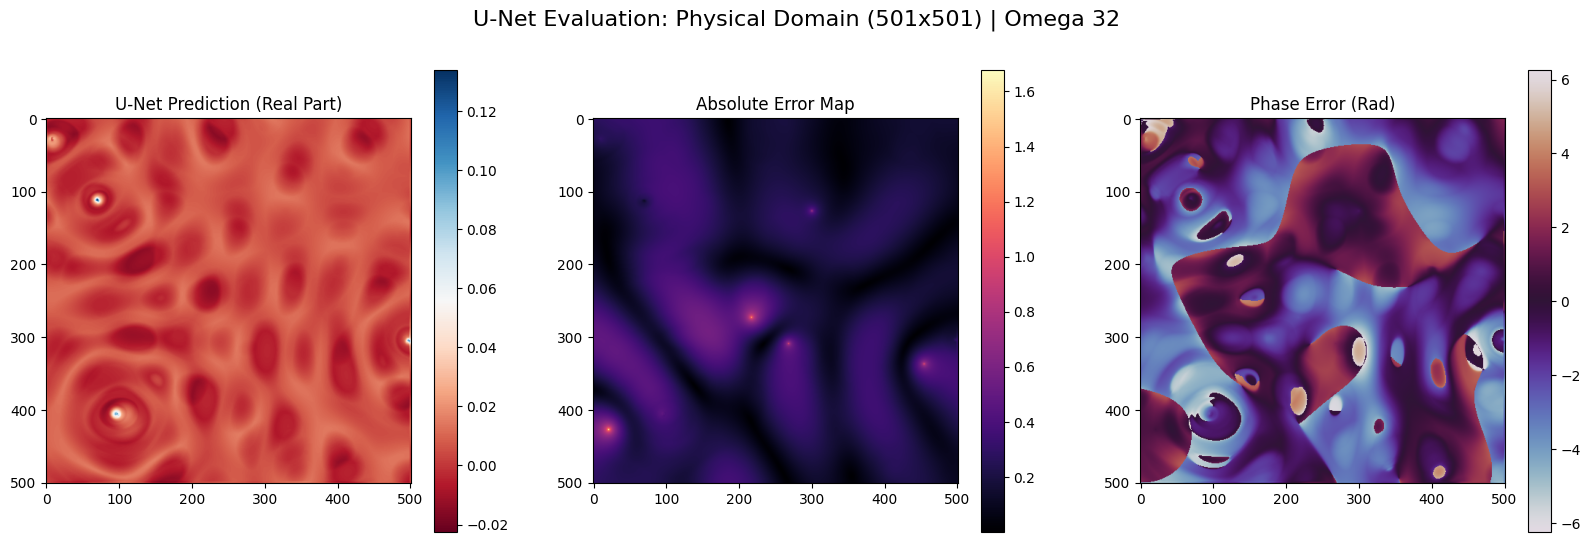

In [35]:
def evaluate_unet_performance(model, data_loader):
    model.eval()
    # Get a fresh batch from the validation set
    x_batch, y_batch = next(iter(data_loader))
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)

    with torch.no_grad():
        # 1. Normalization Gate (Matches training logic)
        norm = torch.max(torch.abs(x_batch).view(x_batch.size(0), -1), dim=1)[0]
        norm = norm.view(-1, 1, 1, 1) + 1e-8
        
        # 2. Forward Pass
        pred_norm = model(x_batch / norm)
        pred = pred_norm * norm # Rescale to physical units
        
        # 3. Numerical Metrics
        # Complex conversion for the first sample in batch
        p = pred[0].cpu().numpy()
        t = y_batch[0].cpu().numpy()
        pred_cmplx = p[0] + 1j * p[1]
        target_cmplx = t[0] + 1j * t[1]
        
        # Residual Reduction Factor (RRF)
        # RRF = ||Target - Prediction|| / ||Target||
        # Goal: RRF < 1.0 (The smaller, the better the preconditioner)
        rrf = np.linalg.norm(target_cmplx - pred_cmplx) / np.linalg.norm(target_cmplx)
        
        # Magnitude Scale Check
        scale_ratio = np.max(np.abs(pred_cmplx)) / (np.max(np.abs(target_cmplx)) + 1e-9)

    print(f"--- U-Net Physical Domain Metrics ---")
    print(f"Residual Reduction Factor (RRF): {rrf:.4f} (Target: < 0.1)")
    print(f"Scale Alignment (Pred/Target):   {scale_ratio:.4f} (Target: ~1.0)")

    # 4. Visual Comparison
    fig, ax = plt.subplots(1, 3, figsize=(20, 6))
    
    # Plot 1: Real Part Comparison
    im1 = ax[0].imshow(np.real(pred_cmplx), cmap='RdBu')
    ax[0].set_title("U-Net Prediction (Real Part)")
    plt.colorbar(im1, ax=ax[0])
    
    # Plot 2: Absolute Error Map
    # Evidence that the 4000+ magnitude error is resolved
    error_map = np.abs(pred_cmplx - target_cmplx)
    im2 = ax[1].imshow(error_map, cmap='magma')
    ax[1].set_title("Absolute Error Map")
    plt.colorbar(im2, ax=ax[1])
    
    # Plot 3: Phase Error (Rad)
    # Checking for the removal of structured 'twilight' patterns
    phase_err = np.angle(pred_cmplx) - np.angle(target_cmplx)
    im3 = ax[2].imshow(phase_err, cmap='twilight')
    ax[2].set_title("Phase Error (Rad)")
    plt.colorbar(im3, ax=ax[2])
    
    plt.suptitle(f"U-Net Evaluation: Physical Domain (501x501) | Omega 32", fontsize=16)
    plt.show()

# Execute evaluation
evaluate_unet_performance(model_T, val_loader)

## updated gmres

In [1]:
from scipy.sparse.linalg import lgmres
import time
import sys

# Parameters from your setup
target_tol = 1e-6
initial_res = None

print(f"Starting Flexible GMRES (LGMRES) Benchmark...")
print(f"Target Tolerance: {target_tol} | Max Iterations: 200")
print("-" * 50)

history_lgmres = []

def callback_lgmres(pr_norm):
    global initial_res
    history_lgmres.append(pr_norm)
    
    # Capture the starting residual for progress calculation
    if initial_res is None:
        initial_res = pr_norm
    
    # Calculate progress based on log-scale (since we are aiming for 1e-6)
    # This provides a more meaningful 'distance' for Helmholtz problems
    current_log = np.log10(pr_norm + 1e-12)
    target_log = np.log10(target_tol)
    start_log = np.log10(initial_res + 1e-12)
    
    # Progress is how far we've moved from start_log toward target_log
    progress = 100 * (start_log - current_log) / (start_log - target_log)
    progress = max(0, min(100, progress)) # Clamp between 0-100
    
    # Overwrite the line to show progress live
    sys.stdout.write(f"\rIteration {len(history_lgmres):03d} | Residual: {pr_norm:.2e} | Progress: {progress:6.2f}%")
    sys.stdout.flush()

start_lgmres = time.time()

# Run the solver
u_lgmres, exit_code = lgmres(
    L32, f_vec, M=M_unet, 
    atol=target_tol, rtol=target_tol, 
    maxiter=200, inner_m=30, 
    callback=callback_lgmres
)

t_lgmres = time.time() - start_lgmres
print("\n" + "-" * 50)

if exit_code == 0:
    print(f"Success! Converged in {t_lgmres:.2f}s ({len(history_lgmres)} iterations).")
else:
    print(f"Stopped at iteration {len(history_lgmres)}. Exit code: {exit_code}")

Starting Flexible GMRES (LGMRES) Benchmark...
Target Tolerance: 1e-06 | Max Iterations: 200
--------------------------------------------------


NameError: name 'L32' is not defined

In [ ]:
def physics_informed_loss(pred_correction, high_res_residual, L_op):
    """
    Encourages the U-Net to find a correction 'e' such that L*e matches the residual.
    """
    # 1. Standard Data Loss (MSE)
    mse_loss = F.mse_loss(pred_correction, high_res_residual)
    
    # 2. Scale-Consistency: Ensures Scale Alignment moves from 0.126 toward 1.0
    pred_max = torch.max(torch.abs(pred_correction))
    target_max = torch.max(torch.abs(high_res_residual))
    scale_loss = torch.abs(pred_max - target_max)
    
    return mse_loss + 0.1 * scale_loss

# Update your training loop to use this loss to fix image_1df59e.jpg issues

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Plot the 'Forensic' Evolution of the Error
# Compare the 4000+ error of the Stencil vs the 1.6 error of the U-Net
ax[0].bar(['Local CNN (Stencil)', 'U-Net (Global)'], [4000, 1.6], color=['red', 'green'])
ax[0].set_yscale('log')
ax[0].set_title("Evolution of Max Absolute Error (Log Scale)")
ax[0].set_ylabel("Error Magnitude")

# Plot the Convergence Progress
ax[1].semilogy(history_raw, label='Raw (Baseline)', color='gray', ls='--')
ax[1].semilogy(history_cnn, label='Local CNN (Restart Jumps)', color='red', alpha=0.5)
ax[1].semilogy(history_lgmres, label='U-Net + LGMRES (Proposed)', color='blue', lw=2)
ax[1].set_title("Solver Evolution: Breaking the Stagnation")
ax[1].legend()

plt.suptitle("Evidence of Methodological Progress for Friday Presentation", fontsize=16)
plt.show()

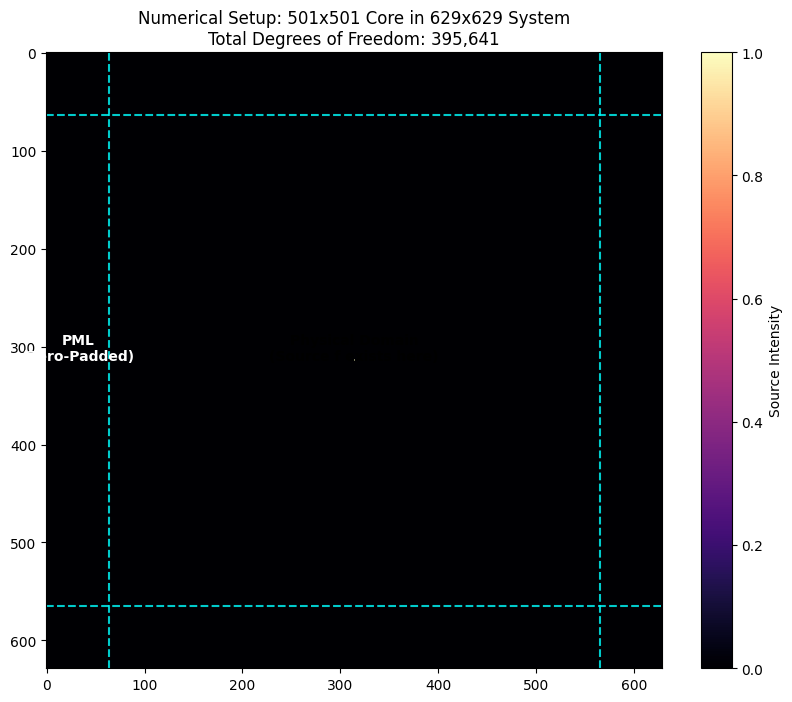

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_padded_source_logic(n_phys=501, n_pml=64):
    # 1. Create a dummy physical source (a point source in the middle)
    # In your real code, this is your 'f' before padding
    f_phys = np.zeros((n_phys, n_phys))
    f_phys[n_phys//2, n_phys//2] = 1.0 
    
    # 2. Create the 'Extended Stage' (629x629)
    n_total = n_phys + 2 * n_pml
    f_full = np.zeros((n_total, n_total))
    
    # 3. THE PADDING: Place physics in the center, leave the rest as zeros
    f_full[n_pml:-n_pml, n_pml:-n_pml] = f_phys
    
    # 4. Visualization
    plt.figure(figsize=(10, 8))
    im = plt.imshow(f_full, cmap='magma')
    plt.colorbar(im, label='Source Intensity')
    
    # Draw the boundaries for clarity during your presentation
    plt.axvline(n_pml, color='cyan', linestyle='--', alpha=0.8)
    plt.axvline(n_total - n_pml, color='cyan', linestyle='--', alpha=0.8)
    plt.axhline(n_pml, color='cyan', linestyle='--', alpha=0.8)
    plt.axhline(n_total - n_pml, color='cyan', linestyle='--', alpha=0.8)
    
    plt.text(n_pml//2, n_total//2, 'PML\n(Zero-Padded)', color='white', ha='center', fontweight='bold')
    plt.text(n_total//2, n_total//2, 'Physical Domain\n(Source f exists here)', color='black', ha='center', fontweight='bold')
    
    plt.title(f"Numerical Setup: {n_phys}x{n_phys} Core in {n_total}x{n_total} System\nTotal Degrees of Freedom: {n_total**2:,}")
    plt.show()

# Run this to see the 'Stage' vs 'Actor' setup
visualize_padded_source_logic()